In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import zscore
from scipy.signal import welch
import antropy as ant



C:\Users\andre\AppData\Local\Temp\ipykernel_19804\4216853584.py:5: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_annotated = pd.read_csv(f'../data/sub-{subj}_merged_annotated.csv')


In [ ]:

# Define the subject identifier
subj = '02'  
#load merged_annotated from csv
merged_annotated = pd.read_csv(f'../data/sub-{subj}_merged_annotated.csv')

In [2]:
# look at merge_annotated
merged_annotated.head()

ecg   respiration  physio_triggers  condition_triggers  sequence  \
0 -2819.863329  52417.981625              1.0         1960.595738     18103   
1 -2825.180449  52409.538460              0.0         1966.334015     18103   
2 -2837.973123  52430.802727              0.0         1962.859462     18104   
3 -2851.818692  52421.734142              0.0         1963.175330     18104   
4 -2848.449428  52441.747570              0.0         1964.754673     18104   

   battery  flags       EEG-ch1       EEG-ch2       EEG-ch3  ...  \
0        4      0  85691.552422  72873.918073  69512.251130  ...   
1        4      0  85698.682692  72894.834344  69513.078534  ...   
2        4      0  85658.614467  72901.137211  69513.285385  ...   
3        4      0  85649.780719  72908.669015  69513.626080  ...   
4        4      0  85668.348624  72880.087095  69488.329438  ...   

       EEG-ch25      EEG-ch26      EEG-ch27       EEG-ch28      EEG-ch29  \
0  65758.553164  99260.225689  80537.900097  102070.026743  76087.710997   
1  65810.302378  99335.263876  80575.133249  102070.026743  76136.065424   
2  65706.402415  99137.246778  80420.676506  102070.026743  76002.220759   
3  65737.259694  99213.465230  80503.392509  102070.026743  76053.069564   
4  65804.036014  99349.451410  80580.572210  102070.026743  76130.808979   

       EEG-ch30      EEG-ch31       EEG-ch32  eeg_triggers  condition_names  
0  80124.271411  78928.223317  102070.026743           1.0                0  
1  80177.918787  78959.372621  102070.026743           0.0                0  
2  80020.395784  78817.947480  102070.026743           0.0                0  
3  80083.789484  78890.174929  102070.026743           0.0                0  
4  80183.479424  78966.636736  102070.026743           0.0                0  

[5 rows x 41 columns]

## preproc

In [ ]:
def _bandpass(x, fs, low=0.5, high=45., order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, x)

def _notch(x, fs, f0=60.0, Q=30.0):
    b, a = iirnotch(f0/(fs/2), Q)
    return filtfilt(b, a, x)

def preprocess_eeg_df(df, eeg_cols, fs_eeg, powerline=60.0):
    """Bandpass 0.5–45 Hz, notch 50/60 Hz, z-score per channel."""
    out = df.copy()
    for ch in eeg_cols:
        x = out[ch].to_numpy(dtype=float)
        x = _bandpass(x, fs_eeg, 0.5, 45.)
        if powerline:
            x = _notch(x, fs_eeg, f0=powerline)
        out[ch] = zscore(x, ddof=1)
    return out



In [ ]:
fs_eeg = 500  # set to your EEG sampling rate
eeg_cols = [c for c in merged_annotated.columns if c.lower().startswith("eeg")]
eeg_pre = preprocess_eeg_df(merged_annotated, eeg_cols, fs_eeg, powerline=60.0)
eeg_pre.head()

Creating RawArray with float64 data, n_channels=33, n_times=503522
    Range : 0 ... 503521 =      0.000 ...  1007.042 secs
Ready.
Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
     50.00 : 6600 windows
     60.00 : 6600 windows
    100.00 : 6600 windows
    120.00 : 6600 windows
    150.00 : 6600 windows
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 991 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


AttributeError: No mne.preprocessing attribute find_bad_channels_threshold

## Features in rolling windows


win_sec = 60 → each window is 60 seconds long
fs = 500 Hz → each window contains 60 × 500 = 30,000 samples
overlap = 0.9 → 90% overlap between consecutive windows
step size = 10% of 30,000 = 3,000 samples
at 500 Hz → step = 3,000 ÷ 500 = 6 seconds

so:
window 1 → 0s to 60s
window 2 → 6s to 66s
window 3 → 12s to 72s
… etc


In [ ]:

# -------------------------------------------------------------------
# Helper: compute relative bandpowers (delta, theta, alpha, beta)
# -------------------------------------------------------------------
def bandpowers(x, fs):
    """
    Compute relative band power features from an EEG segment.

    Parameters
    ----------
    x : 1D array-like
        EEG segment (samples).
    fs : int or float
        Sampling frequency in Hz.

    Returns
    -------
    out : dict
        Keys are 'BP_delta_rel', 'BP_theta_rel', 'BP_alpha_rel', 'BP_beta_rel'.
        Values are relative power (band / total power).
    """
    # Power spectral density via Welch's method
    f, Pxx = welch(x, fs=fs, nperseg=min(int(4*fs), len(x)))
    total = np.trapz(Pxx, f)  # total power across spectrum

    # Define standard EEG frequency bands
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta":  (13, 30)
    }

    out = {}
    for name, (lo, hi) in bands.items():
        idx = (f >= lo) & (f <= hi)   # frequency mask
        bp = np.trapz(Pxx[idx], f[idx])   # integrate PSD in band
        out[f"BP_{name}_rel"] = (bp / total) if total > 0 else np.nan

    return out


# -------------------------------------------------------------------
# Main: rolling EEG feature extraction (multi-channel)
# -------------------------------------------------------------------
def rolling_eeg_features_multich(df, eeg_cols, fs, win_sec=60, overlap=0.9):
    """
    Compute rolling EEG features (entropy, complexity, bandpower) 
    across multiple channels.

    Parameters
    ----------
    df : pandas.DataFrame
        Preprocessed EEG data (only EEG columns).
    eeg_cols : list of str
        Names of EEG channels in df.
    fs : int or float
        Sampling frequency of EEG in Hz.
    win_sec : int or float, default=60
        Window size in seconds for rolling feature extraction.
    overlap : float, default=0.9
        Overlap between consecutive windows (0.0 = no overlap, 
        0.9 = 90% overlap).

    Returns
    -------
    features_df : pandas.DataFrame
        Tidy-format dataframe with one row per (window × channel).
        Columns:
            - channel        : str, channel name
            - win_start_idx  : int, starting sample index of window
            - time_sec       : float, window start time in seconds
            - SpecEnt        : spectral entropy
            - PermEnt        : permutation entropy
            - LZC            : Lempel–Ziv complexity
            - BP_delta_rel   : relative delta power
            - BP_theta_rel   : relative theta power
            - BP_alpha_rel   : relative alpha power
            - BP_beta_rel    : relative beta power
    """
    # Number of samples per window
    win_samples = int(win_sec * fs)
    # Step size = non-overlapped portion
    step_samples = int(win_samples * (1 - overlap))
    rows = []  # store feature dicts

    # Loop over window start positions
    for start in range(0, len(df) - win_samples + 1, step_samples):
        seg_time = start / fs  # convert sample index to seconds

        # Process each channel separately
        for ch in eeg_cols:
            segment = df[ch].values[start:start+win_samples]

            try:
                # --- Entropy features ---
                spec = ant.spectral_entropy(segment, sf=fs, method="welch", normalize=True)
                perm = ant.perm_entropy(segment, order=3, delay=1, normalize=True)

                # --- Lempel–Ziv complexity ---
                # binarize around median before LZC
                bin_seq = (segment > np.median(segment)).astype(int)
                lzc = ant.lziv_complexity(bin_seq, normalize=True)

                # --- Bandpowers ---
                bp_feats = bandpowers(segment, fs)

                # Collect features
                feats = {
                    "SpecEnt": spec,
                    "PermEnt": perm,
                    "LZC": lzc
                }
                feats.update(bp_feats)

            except Exception:
                # If feature extraction fails, fill with NaN
                feats = {
                    "SpecEnt": np.nan,
                    "PermEnt": np.nan,
                    "LZC": np.nan,
                    "BP_delta_rel": np.nan,
                    "BP_theta_rel": np.nan,
                    "BP_alpha_rel": np.nan,
                    "BP_beta_rel": np.nan
                }

            # Add metadata
            feats.update({
                "channel": ch,
                "win_start_idx": start,
                "time_sec": seg_time
            })

            rows.append(feats)

    # Convert to tidy dataframe
    return pd.DataFrame(rows)


In [11]:
# Compute rolling features for the 32 EEG channels
feats_all = rolling_eeg_features_multich(
    eeg_pre, eeg_cols, fs=fs_eeg, win_sec=60, overlap=0.9
)

print(feats_all.head())


    SpecEnt   PermEnt       LZC  BP_delta_rel  BP_theta_rel  BP_alpha_rel  \
0  0.339415  0.655668  0.151206      0.753948      0.043520      0.008022   
1  0.340160  0.650772  0.145256      0.756523      0.032094      0.009186   
2  0.326278  0.652600  0.136829      0.757365      0.029380      0.007807   
3  0.363217  0.652531  0.168061      0.759198      0.032875      0.010914   
4  0.387488  0.651603  0.195328      0.737617      0.041605      0.012336   

   BP_beta_rel  channel  win_start_idx  time_sec  
0     0.013590  EEG-ch1              0       0.0  
1     0.014977  EEG-ch2              0       0.0  
2     0.012421  EEG-ch3              0       0.0  
3     0.022440  EEG-ch4              0       0.0  
4     0.031930  EEG-ch5              0       0.0  


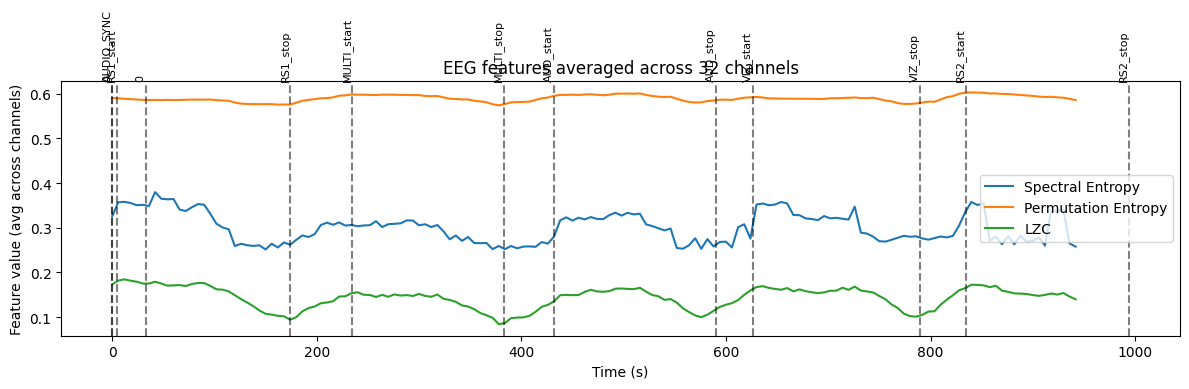

In [ ]:
def get_condition_segments(df, conditions):
    """Return a dict of start/stop indices for each condition"""
    indices = {}
    for cond in conditions:
        # Find all indices labeled as this condition
        cond_idx = df.index[df['condition_names'] == cond].tolist()
        if cond_idx:
            # Assume one continuous segment per condition
            indices[cond] = (cond_idx[0])
        else:
            indices[cond] = None
    return indices

indices = get_condition_segments(merged_annotated, merged_annotated['condition_names'].unique())
indices

# 1) average across all channels for each window
avg_feats = (feats_all
             .groupby("time_sec")[["SpecEnt","PermEnt","LZC"]]
             .mean()
             .reset_index())

# 2) plot with condition boundaries
plt.figure(figsize=(12,4))
plt.plot(avg_feats["time_sec"], avg_feats["SpecEnt"], label="Spectral Entropy")
plt.plot(avg_feats["time_sec"], avg_feats["PermEnt"], label="Permutation Entropy")
plt.plot(avg_feats["time_sec"], avg_feats["LZC"], label="LZC")

# add vertical lines + labels for conditions
for name, idx in indices.items():
    if idx is not None:
        t = idx / fs_eeg
        plt.axvline(t, color='k', linestyle='--', alpha=0.5)
        plt.text(t, plt.ylim()[1], name, rotation=90,
                 va='bottom', ha='right', fontsize=8)

plt.xlabel("Time (s)")
plt.ylabel("Feature value (avg across channels)")
plt.legend()
plt.title("EEG features averaged across 32 channels")
plt.tight_layout()
plt.show()


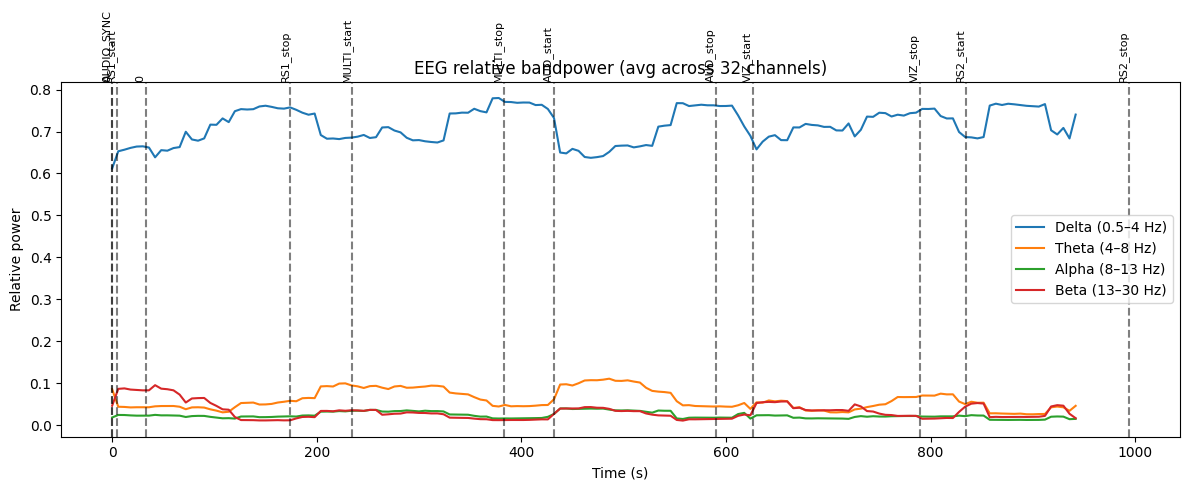

In [15]:
# average bandpowers across channels for each window
bp_avg = (feats_all
          .groupby("time_sec")[["BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"]]
          .mean()
          .reset_index())

plt.figure(figsize=(12,5))
plt.plot(bp_avg["time_sec"], bp_avg["BP_delta_rel"], label="Delta (0.5–4 Hz)")
plt.plot(bp_avg["time_sec"], bp_avg["BP_theta_rel"], label="Theta (4–8 Hz)")
plt.plot(bp_avg["time_sec"], bp_avg["BP_alpha_rel"], label="Alpha (8–13 Hz)")
plt.plot(bp_avg["time_sec"], bp_avg["BP_beta_rel"], label="Beta (13–30 Hz)")

# add condition boundaries
for name, idx in indices.items():
    if idx is not None:
        t = idx / fs_eeg
        plt.axvline(t, color='k', linestyle='--', alpha=0.5)
        plt.text(t, plt.ylim()[1], name, rotation=90, va='bottom', ha='right', fontsize=8)

plt.xlabel("Time (s)")
plt.ylabel("Relative power")
plt.title("EEG relative bandpower (avg across 32 channels)")
plt.legend()
plt.tight_layout()
plt.show()


## one channel example

In [16]:
import antropy as ant

def rolling_eeg_entropy(signal, fs, win_sec=60, overlap=0.9):
    win_samples = int(win_sec * fs)
    step_samples = int(win_samples * (1 - overlap))
    feats, win_starts = [], []

    for start in range(0, len(signal) - win_samples + 1, step_samples):
        segment = signal[start:start+win_samples]
        try:
            feats.append({
                "SpecEnt": ant.spectral_entropy(segment, sf=fs, method='welch', normalize=True),
                "PermEnt": ant.perm_entropy(segment, order=3, delay=1, normalize=True)
            })
        except Exception:
            feats.append({"SpecEnt": np.nan, "PermEnt": np.nan})
        win_starts.append(start)

    return feats, np.array(win_starts)


Testing channel: EEG-ch1


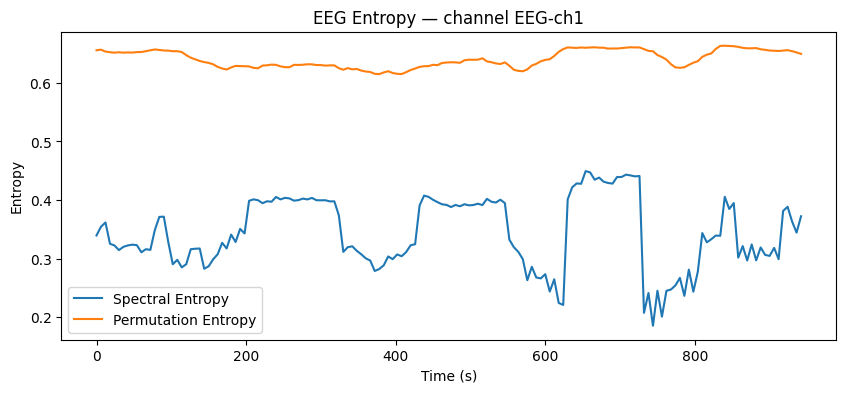

In [18]:
ch = eeg_cols[0]   # first EEG channel name
print("Testing channel:", ch)

feats, starts = rolling_eeg_entropy(eeg_pre[ch].values, fs_eeg, win_sec=60, overlap=0.9)

import pandas as pd
feats_df = pd.DataFrame(feats)
feats_df["win_start_idx"] = starts
feats_df.head()

import matplotlib.pyplot as plt
time_sec = feats_df["win_start_idx"] / fs_eeg

plt.figure(figsize=(10,4))
plt.plot(time_sec, feats_df["SpecEnt"], label="Spectral Entropy")
plt.plot(time_sec, feats_df["PermEnt"], label="Permutation Entropy")
plt.xlabel("Time (s)")
plt.ylabel("Entropy")
plt.legend()
plt.title(f"EEG Entropy — channel {ch}")
plt.show()



In [ ]:
def get_condition_segments(df, conditions):
    """Return a dict of start/stop indices for each condition"""
    indices = {}
    for cond in conditions:
        # Find all indices labeled as this condition
        cond_idx = df.index[df['condition_names'] == cond].tolist()
        if cond_idx:
            # Assume one continuous segment per condition
            indices[cond] = (cond_idx[0])
        else:
            indices[cond] = None
    return indices

indices = get_condition_segments(merged_annotated, merged_annotated['condition_names'].unique())
indices

{'0': 0,
 'AUDIO_SYNC': 151,
 'RS1_start': 2525,
 0: 16384,
 'RS1_stop': 87125,
 'MULTI_start': 117402,
 'MULTI_stop': 191484,
 'AUD_start': 216123,
 'AUD_stop': 294877,
 'VIZ_start': 313318,
 'VIZ_stop': 394651,
 'RS2_start': 417403,
 'RS2_stop': 496983}

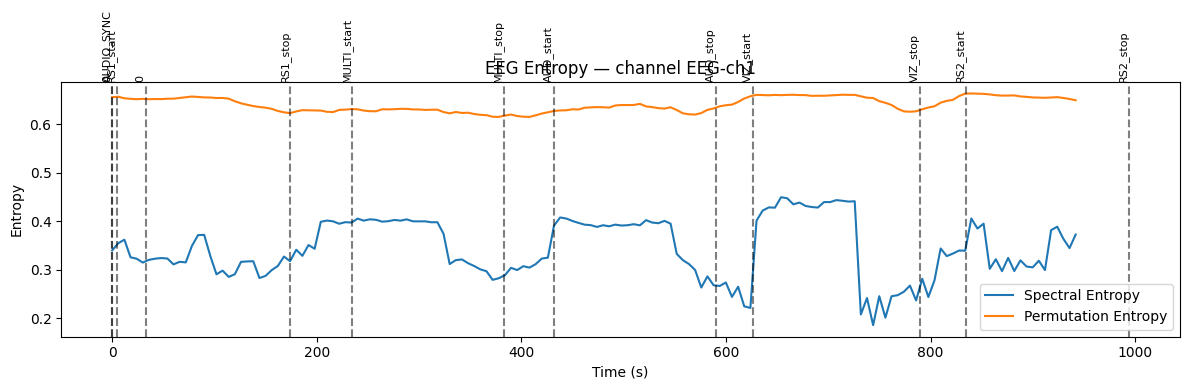

In [21]:
plt.figure(figsize=(12,4))
plt.plot(time_sec, feats_df["SpecEnt"], label="Spectral Entropy")
plt.plot(time_sec, feats_df["PermEnt"], label="Permutation Entropy")

# mark condition boundaries
for name, idx in indices.items():
    if idx is not None:
        t = idx / fs_eeg   # convert sample index to seconds
        plt.axvline(t, color='k', linestyle='--', alpha=0.5)
        plt.text(t, plt.ylim()[1], name, rotation=90, va='bottom', ha='right', fontsize=8)

plt.xlabel("Time (s)")
plt.ylabel("Entropy")
plt.legend()
plt.title(f"EEG Entropy — channel {ch}")
plt.tight_layout()
plt.show()


## multichannel

In [22]:
def rolling_eeg_entropy_multich(df, eeg_cols, fs, win_sec=60, overlap=0.9):
    """Compute rolling entropy for all channels in df[eeg_cols]."""
    all_feats = []
    win_samples = int(win_sec * fs)
    step_samples = int(win_samples * (1 - overlap))

    for start in range(0, len(df) - win_samples + 1, step_samples):
        seg_time = start / fs
        for ch in eeg_cols:
            segment = df[ch].values[start:start+win_samples]
            try:
                spec = ant.spectral_entropy(segment, sf=fs, method='welch', normalize=True)
                perm = ant.perm_entropy(segment, order=3, delay=1, normalize=True)
            except Exception:
                spec, perm = np.nan, np.nan
            all_feats.append({
                "channel": ch,
                "win_start_idx": start,
                "time_sec": seg_time,
                "SpecEnt": spec,
                "PermEnt": perm
            })
    return pd.DataFrame(all_feats)


In [23]:
feats_all = rolling_eeg_entropy_multich(eeg_pre, eeg_cols, fs=fs_eeg, win_sec=60, overlap=0.9)
feats_all.head()


channel  win_start_idx  time_sec   SpecEnt   PermEnt
0  EEG-ch1              0       0.0  0.339415  0.655668
1  EEG-ch2              0       0.0  0.340160  0.650772
2  EEG-ch3              0       0.0  0.326278  0.652600
3  EEG-ch4              0       0.0  0.363217  0.652531
4  EEG-ch5              0       0.0  0.387488  0.651603

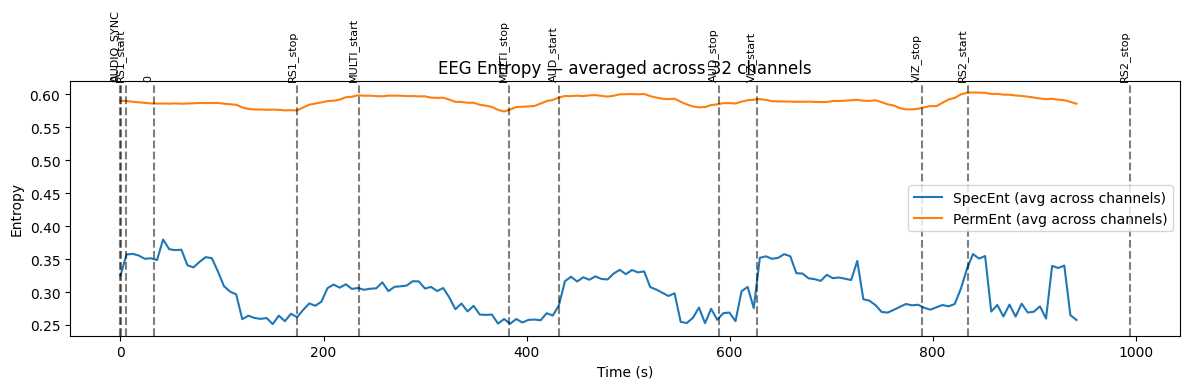

In [25]:
plt.figure(figsize=(12,4))
plt.plot(avg_feats["time_sec"], avg_feats["SpecEnt"], label="SpecEnt (avg across channels)")
plt.plot(avg_feats["time_sec"], avg_feats["PermEnt"], label="PermEnt (avg across channels)")

# add vertical lines for condition markers
for name, idx in indices.items():
    if idx is not None:
        t = idx / fs_eeg
        plt.axvline(t, color='k', linestyle='--', alpha=0.5)
        plt.text(t, plt.ylim()[1], name, rotation=90, va='bottom', ha='right', fontsize=8)

plt.xlabel("Time (s)")
plt.ylabel("Entropy")
plt.legend()
plt.title("EEG Entropy — averaged across 32 channels")
plt.tight_layout()
plt.show()


slice the big feats_all dataframe into condition-specific blocks.

RS1 (957, 10)
MULTI (792, 10)
AUD (858, 10)
VIZ (891, 10)
RS2 (594, 10)


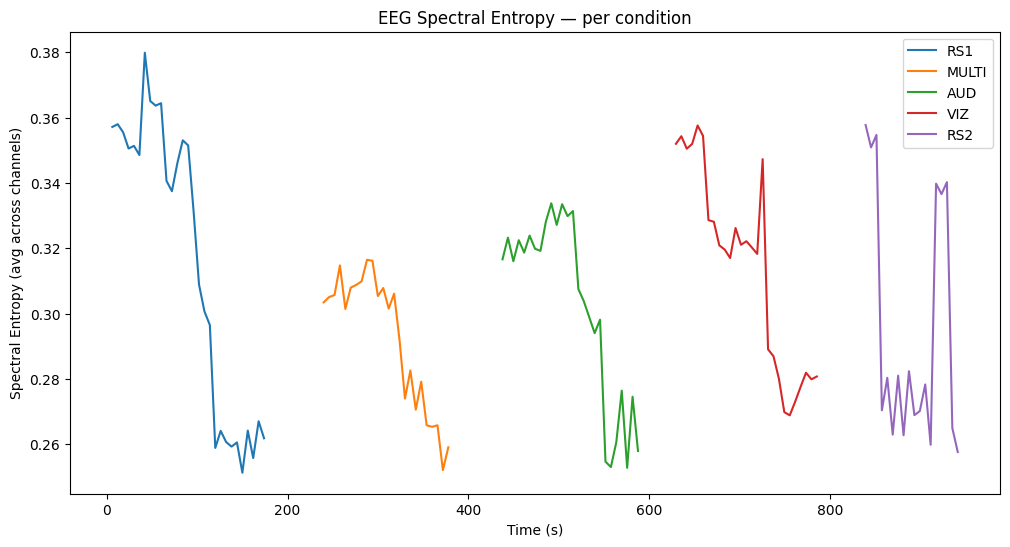

In [17]:
def split_by_condition(feats_all, indices, fs):
    cond_dict = {}
    for cond in ["RS1","MULTI","AUD","VIZ","RS2"]:
        start = indices.get(f"{cond}_start")
        stop  = indices.get(f"{cond}_stop")
        if start is not None and stop is not None:
            start_t = start / fs
            stop_t  = stop  / fs
            cond_df = feats_all[(feats_all["time_sec"] >= start_t) &
                                (feats_all["time_sec"] <= stop_t)]
            cond_dict[cond] = cond_df.copy()
    return cond_dict


cond_feats = split_by_condition(feats_all, indices, fs_eeg)
for k,v in cond_feats.items():
    print(k, v.shape)


plt.figure(figsize=(12,6))
for cond, df in cond_feats.items():
    avg = df.groupby("time_sec")[["SpecEnt"]].mean()
    plt.plot(avg.index, avg["SpecEnt"], label=cond)

plt.xlabel("Time (s)")
plt.ylabel("Spectral Entropy (avg across channels)")
plt.legend()
plt.title("EEG Spectral Entropy — per condition")
plt.show()


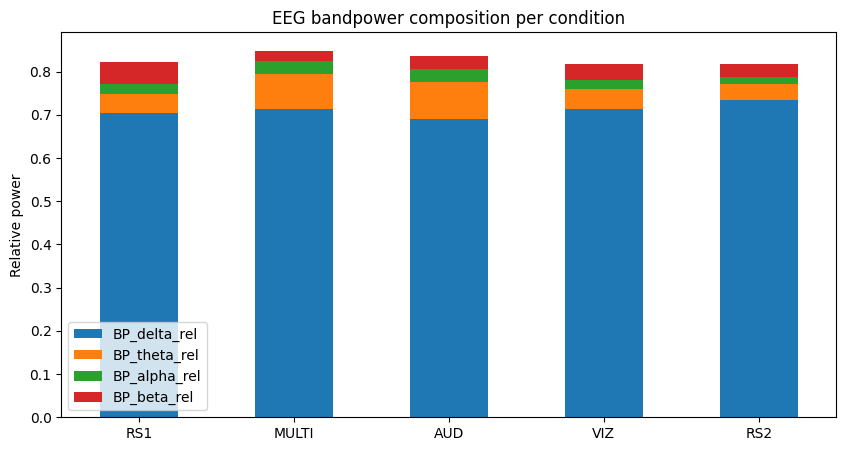

In [18]:
cond_bp_means = {cond: df[["BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"]].mean()
                 for cond, df in cond_feats.items()}
cond_bp_df = pd.DataFrame(cond_bp_means).T

cond_bp_df.plot(kind="bar", stacked=True, figsize=(10,5))
plt.ylabel("Relative power")
plt.title("EEG bandpower composition per condition")
plt.xticks(rotation=0)
plt.show()


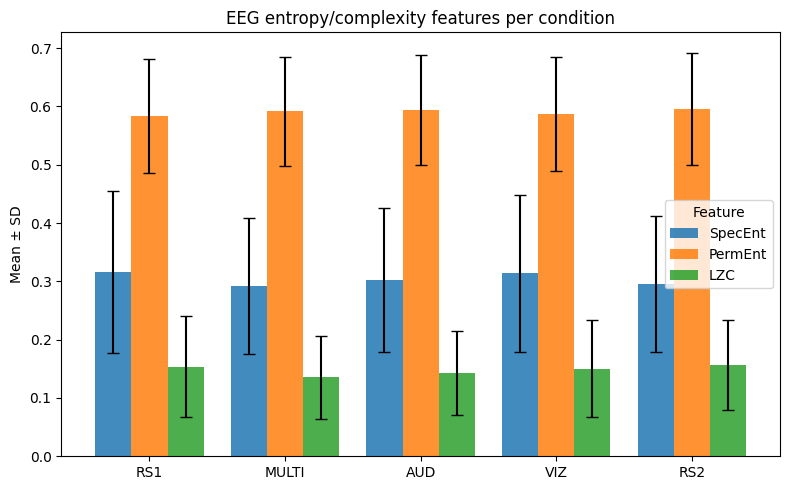

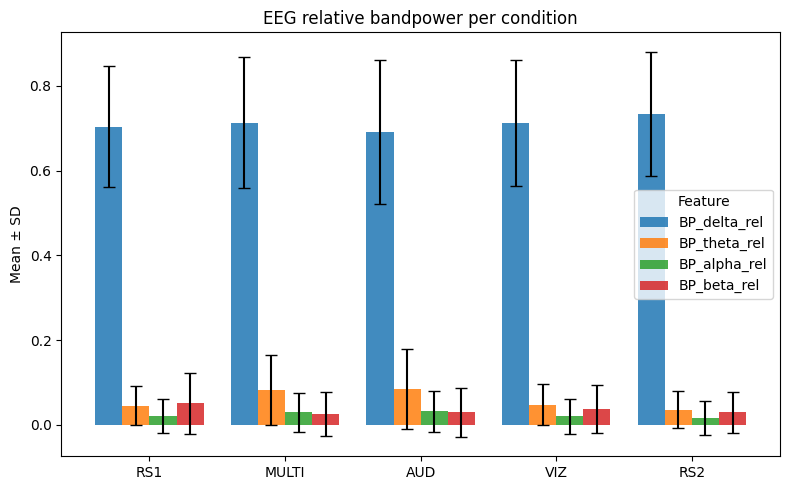

In [20]:
def condition_feature_stats(cond_feats):
    """
    Compute mean and std for all features per condition.

    Parameters
    ----------
    cond_feats : dict[str, pd.DataFrame]
        Dict mapping condition -> feature dataframe.

    Returns
    -------
    cond_mean_df : pd.DataFrame
        Mean values (rows = conditions, cols = features).
    cond_std_df : pd.DataFrame
        Standard deviations (rows = conditions, cols = features).
    """
    cond_means, cond_stds = {}, {}
    for cond, df in cond_feats.items():
        feat_cols = [c for c in df.columns if c not in ["channel","win_start_idx","time_sec"]]
        cond_means[cond] = df[feat_cols].mean()
        cond_stds[cond] = df[feat_cols].std()
    return pd.DataFrame(cond_means).T, pd.DataFrame(cond_stds).T

cond_mean_df, cond_std_df = condition_feature_stats(cond_feats)


def plot_condition_bars(cond_mean_df, cond_std_df, features, title):
    """
    Plot barplot with error bars (mean ± std) for selected features.

    Parameters
    ----------
    cond_mean_df : pd.DataFrame
        Mean values (rows = conditions, cols = features).
    cond_std_df : pd.DataFrame
        Standard deviations (rows = conditions, cols = features).
    features : list[str]
        Features to plot.
    title : str
        Title of the plot.
    """
    ax = cond_mean_df[features].plot(
        kind="bar", 
        yerr=cond_std_df[features].values.T,
        figsize=(8,5), 
        capsize=4, 
        alpha=0.85, 
        width=0.8
    )
    ax.set_ylabel("Mean ± SD")
    ax.set_title(title)
    ax.legend(title="Feature")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Entropy & complexity
plot_condition_bars(cond_mean_df, cond_std_df,
                    ["SpecEnt","PermEnt","LZC"],
                    "EEG entropy/complexity features per condition")

# Bandpowers
plot_condition_bars(cond_mean_df, cond_std_df,
                    ["BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"],
                    "EEG relative bandpower per condition")



### normalised (to do)

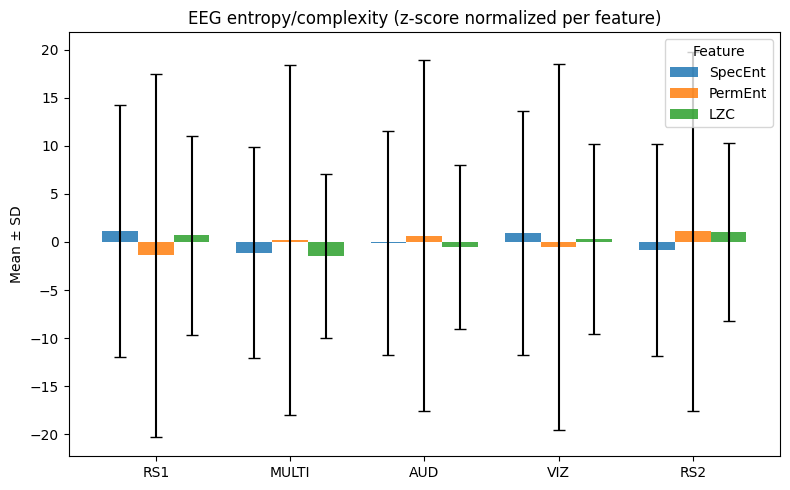

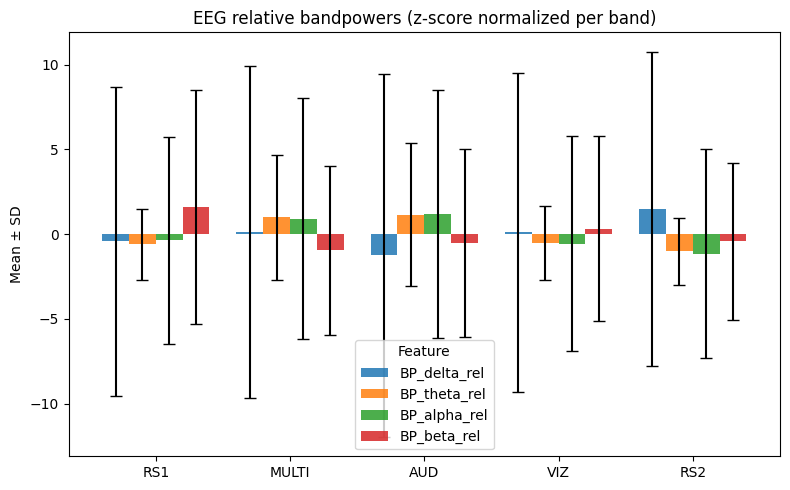

In [29]:
def normalize_feature_stats(cond_mean_df, cond_std_df, method="zscore"):
    """
    Normalize feature means and stds across conditions.

    Parameters
    ----------
    cond_mean_df : pd.DataFrame
        Mean values (rows = conditions, cols = features).
    cond_std_df : pd.DataFrame
        Std values (rows = conditions, cols = features).
    method : str
        'zscore' (mean=0, std=1) or 'minmax' (0-1 scaling).

    Returns
    -------
    norm_mean_df, norm_std_df : pd.DataFrame
        Normalized mean and std dataframes.
    """
    norm_mean, norm_std = {}, {}

    for col in cond_mean_df.columns:
        if method == "zscore":
            m, s = cond_mean_df[col].mean(), cond_mean_df[col].std()
            norm_mean[col] = (cond_mean_df[col] - m) / s if s > 0 else cond_mean_df[col]*0
            norm_std[col] = cond_std_df[col] / s if s > 0 else cond_std_df[col]*0

        elif method == "minmax":
            lo, hi = cond_mean_df[col].min(), cond_mean_df[col].max()
            rng = hi - lo
            norm_mean[col] = (cond_mean_df[col] - lo) / rng if rng > 0 else cond_mean_df[col]*0
            norm_std[col] = cond_std_df[col] / rng if rng > 0 else cond_std_df[col]*0

    return pd.DataFrame(norm_mean), pd.DataFrame(norm_std)

norm_mean_df, norm_std_df = normalize_feature_stats(cond_mean_df, cond_std_df, method="zscore")

# Entropy/complexity normalized
plot_condition_bars(norm_mean_df, norm_std_df,
                    ["SpecEnt","PermEnt","LZC"],
                    "EEG entropy/complexity (z-score normalized per feature)")

# Bandpowers normalized
plot_condition_bars(norm_mean_df, norm_std_df,
                    ["BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"],
                    "EEG relative bandpowers (z-score normalized per band)")



topomaps.

1. per-channel values (e.g. mean SpecEnt per channel within a condition)

2. channel positions (montage info)

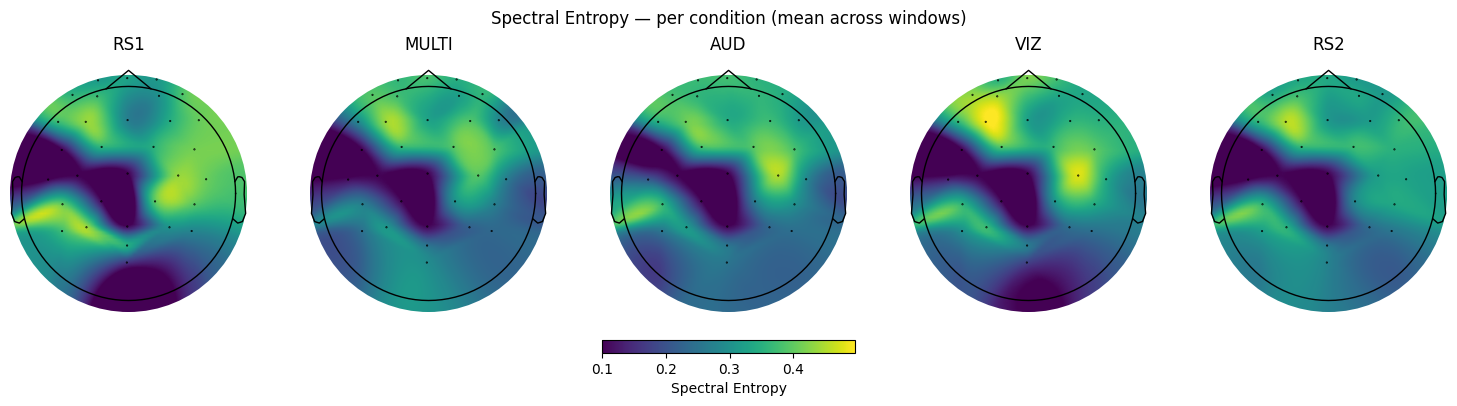

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# -------------------------------------------------------------------
# 1) Compute per-channel means (example: SpecEnt & PermEnt)
# -------------------------------------------------------------------
per_channel = {}
for cond, df in cond_feats.items():
    per_channel[cond] = (df.groupby("channel")[["SpecEnt","PermEnt"]]
                           .mean()
                           .sort_index())   # ensures consistent order

# -------------------------------------------------------------------
# 2) Rename map: EEG-chN -> 10-20 names (Bitbrain 32 layout)
# -------------------------------------------------------------------
rename_map = {
    "EEG-ch1": "Fp1", "EEG-ch2": "Fpz", "EEG-ch3": "Fp2",
    "EEG-ch4": "AF7", "EEG-ch5": "AF3", "EEG-ch6": "AF4", "EEG-ch7": "AF8",
    "EEG-ch8": "F7", "EEG-ch9": "F3", "EEG-ch10": "Fz", "EEG-ch11": "F4", "EEG-ch12": "F8",
    "EEG-ch13": "FC5", "EEG-ch14": "FC1", "EEG-ch15": "FC2", "EEG-ch16": "FC6",
    "EEG-ch17": "T7", "EEG-ch18": "C3", "EEG-ch19": "Cz", "EEG-ch20": "C4", "EEG-ch21": "T8",
    "EEG-ch22": "CP5", "EEG-ch23": "CP1", "EEG-ch24": "CP2", "EEG-ch25": "CP6",
    "EEG-ch26": "P7", "EEG-ch27": "P3", "EEG-ch28": "Pz", "EEG-ch29": "P4", "EEG-ch30": "P8",
    "EEG-ch31": "POz", "EEG-ch32": "Oz"
}

# -------------------------------------------------------------------
# 3) Define Bitbrain32 labels in correct order
# -------------------------------------------------------------------
bitbrain32_labels = [
    "Fp1","Fpz","Fp2",
    "AF7","AF3","AF4","AF8",
    "F7","F3","Fz","F4","F8",
    "FC5","FC1","FC2","FC6",
    "T7","C3","Cz","C4","T8",
    "CP5","CP1","CP2","CP6",
    "P7","P3","Pz","P4","P8",
    "POz","Oz"
]

# -------------------------------------------------------------------
# 4) Create MNE info object with montage
# -------------------------------------------------------------------
info = mne.create_info(
    ch_names=bitbrain32_labels,
    sfreq=fs_eeg,      # <-- your EEG sampling frequency
    ch_types="eeg"
)
montage = mne.channels.make_standard_montage("standard_1020")
info.set_montage(montage)

# -------------------------------------------------------------------
# 5) Plot topomaps for all conditions (example: SpecEnt)
# -------------------------------------------------------------------
conds = ["RS1","MULTI","AUD","VIZ","RS2"]
fig, axes = plt.subplots(1, len(conds), figsize=(15,4), constrained_layout=True)

# gather all values for common color scale
all_vals = []
for cond in conds:
    vals = per_channel[cond]["SpecEnt"].rename(index=rename_map).reindex(bitbrain32_labels)
    all_vals.append(vals.to_numpy(dtype=float))
all_vals = np.hstack(all_vals)
vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

# plot per condition
im_list = []
for ax, cond in zip(axes, conds):
    vals = per_channel[cond]["SpecEnt"].rename(index=rename_map).reindex(bitbrain32_labels)
    data = vals.to_numpy(dtype=float)
    im, cn = mne.viz.plot_topomap(data, info, cmap="viridis", contours=0,
                                  outlines="head", axes=ax, show=False)
    im.set_clim(vmin, vmax)
    ax.set_title(cond)
    im_list.append(im)

# add shared colorbar below
cbar = fig.colorbar(im_list[0], ax=axes, orientation='horizontal',
                    fraction=0.05, pad=0.1)
cbar.set_label("Spectral Entropy")

plt.suptitle("Spectral Entropy — per condition (mean across windows)")
plt.show()


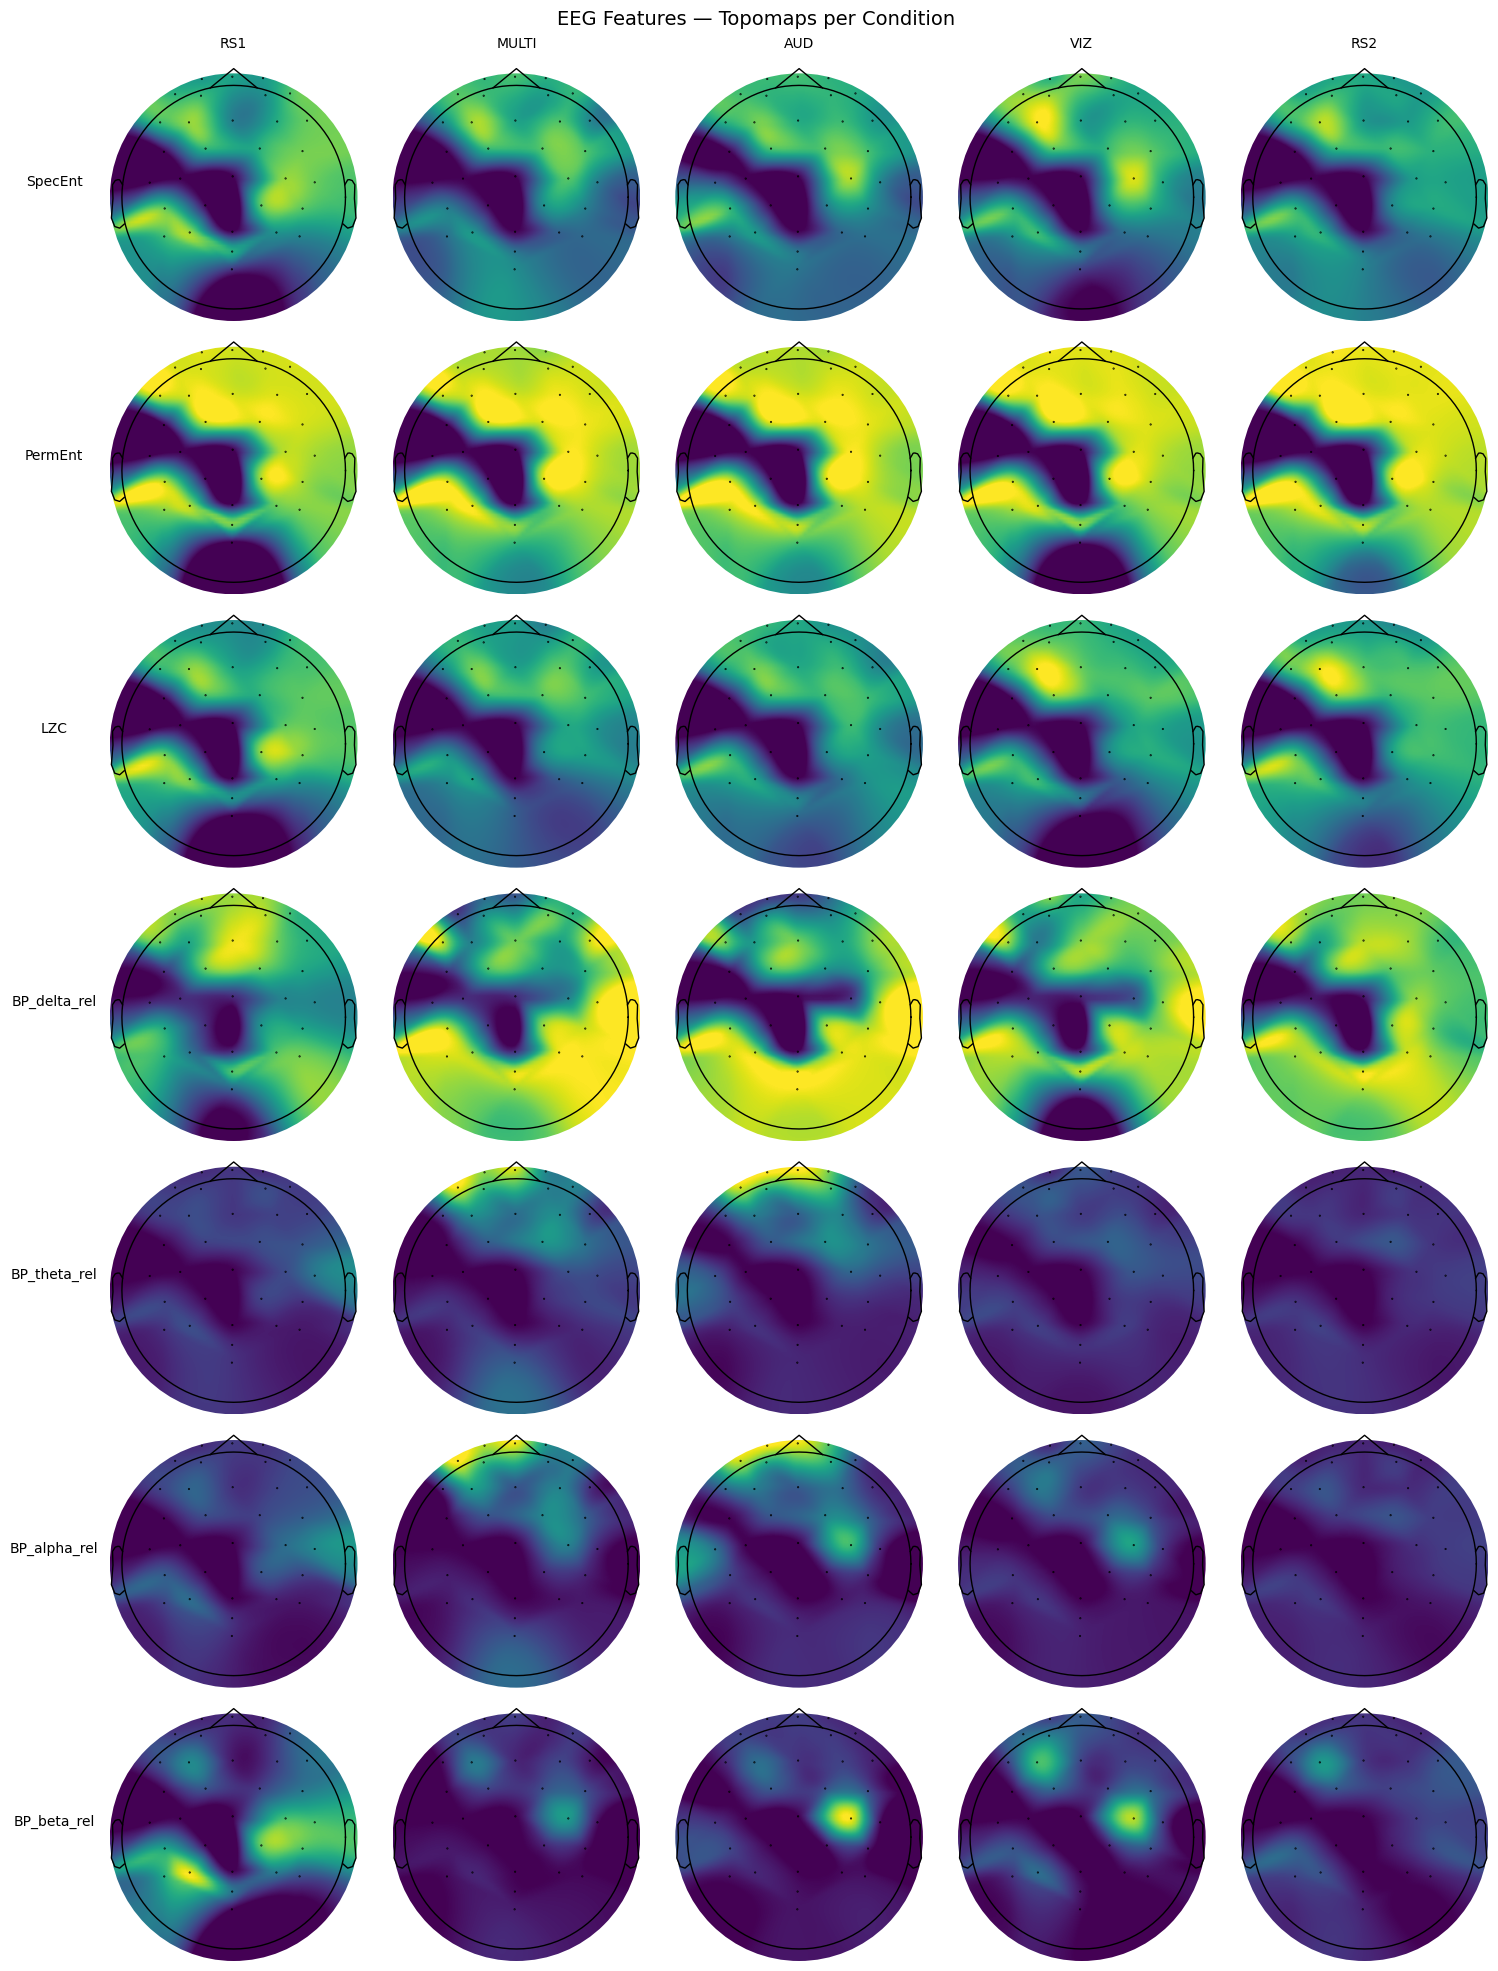

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# -------------------------------------------------------------------
# 1) Per-channel averages (all features)
# -------------------------------------------------------------------
per_channel = {}
for cond, df in cond_feats.items():
    per_channel[cond] = (
        df.groupby("channel")[["SpecEnt","PermEnt","LZC",
                               "BP_delta_rel","BP_theta_rel",
                               "BP_alpha_rel","BP_beta_rel"]]
          .mean()
          .sort_index()
    )

# -------------------------------------------------------------------
# 2) Rename map + channel order
# -------------------------------------------------------------------
rename_map = {
    "EEG-ch1": "Fp1", "EEG-ch2": "Fpz", "EEG-ch3": "Fp2",
    "EEG-ch4": "AF7", "EEG-ch5": "AF3", "EEG-ch6": "AF4", "EEG-ch7": "AF8",
    "EEG-ch8": "F7", "EEG-ch9": "F3", "EEG-ch10": "Fz", "EEG-ch11": "F4", "EEG-ch12": "F8",
    "EEG-ch13": "FC5", "EEG-ch14": "FC1", "EEG-ch15": "FC2", "EEG-ch16": "FC6",
    "EEG-ch17": "T7", "EEG-ch18": "C3", "EEG-ch19": "Cz", "EEG-ch20": "C4", "EEG-ch21": "T8",
    "EEG-ch22": "CP5", "EEG-ch23": "CP1", "EEG-ch24": "CP2", "EEG-ch25": "CP6",
    "EEG-ch26": "P7", "EEG-ch27": "P3", "EEG-ch28": "Pz", "EEG-ch29": "P4", "EEG-ch30": "P8",
    "EEG-ch31": "POz", "EEG-ch32": "Oz"
}
bitbrain32_labels = [
    "Fp1","Fpz","Fp2",
    "AF7","AF3","AF4","AF8",
    "F7","F3","Fz","F4","F8",
    "FC5","FC1","FC2","FC6",
    "T7","C3","Cz","C4","T8",
    "CP5","CP1","CP2","CP6",
    "P7","P3","Pz","P4","P8",
    "POz","Oz"
]

# -------------------------------------------------------------------
# 3) MNE info + montage
# -------------------------------------------------------------------
info = mne.create_info(ch_names=bitbrain32_labels, sfreq=fs_eeg, ch_types="eeg")
montage = mne.channels.make_standard_montage("standard_1020")
info.set_montage(montage)

# -------------------------------------------------------------------
# 4) Grid plot: features × conditions
# -------------------------------------------------------------------
conds = ["RS1","MULTI","AUD","VIZ","RS2"]
features = ["SpecEnt","PermEnt","LZC",
            "BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"]

n_rows, n_cols = len(features), len(conds)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2.8*n_rows),
                         constrained_layout=True)

for i, feat in enumerate(features):
    # shared color scale across conditions for this feature
    all_vals = []
    for cond in conds:
        vals = per_channel[cond][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        all_vals.append(vals.to_numpy(dtype=float))
    all_vals = np.hstack(all_vals)
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    for j, cond in enumerate(conds):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        vals = per_channel[cond][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        data = vals.to_numpy(dtype=float)
        im, cn = mne.viz.plot_topomap(data, info, cmap="viridis", contours=0,
                                      outlines="head", axes=ax, show=False)
        im.set_clim(vmin, vmax)
        if i == 0:
            ax.set_title(cond, fontsize=10)
        if j == 0:
            ax.set_ylabel(feat, fontsize=10, rotation=0, labelpad=40)

fig.suptitle("EEG Features — Topomaps per Condition", fontsize=14)
plt.show()


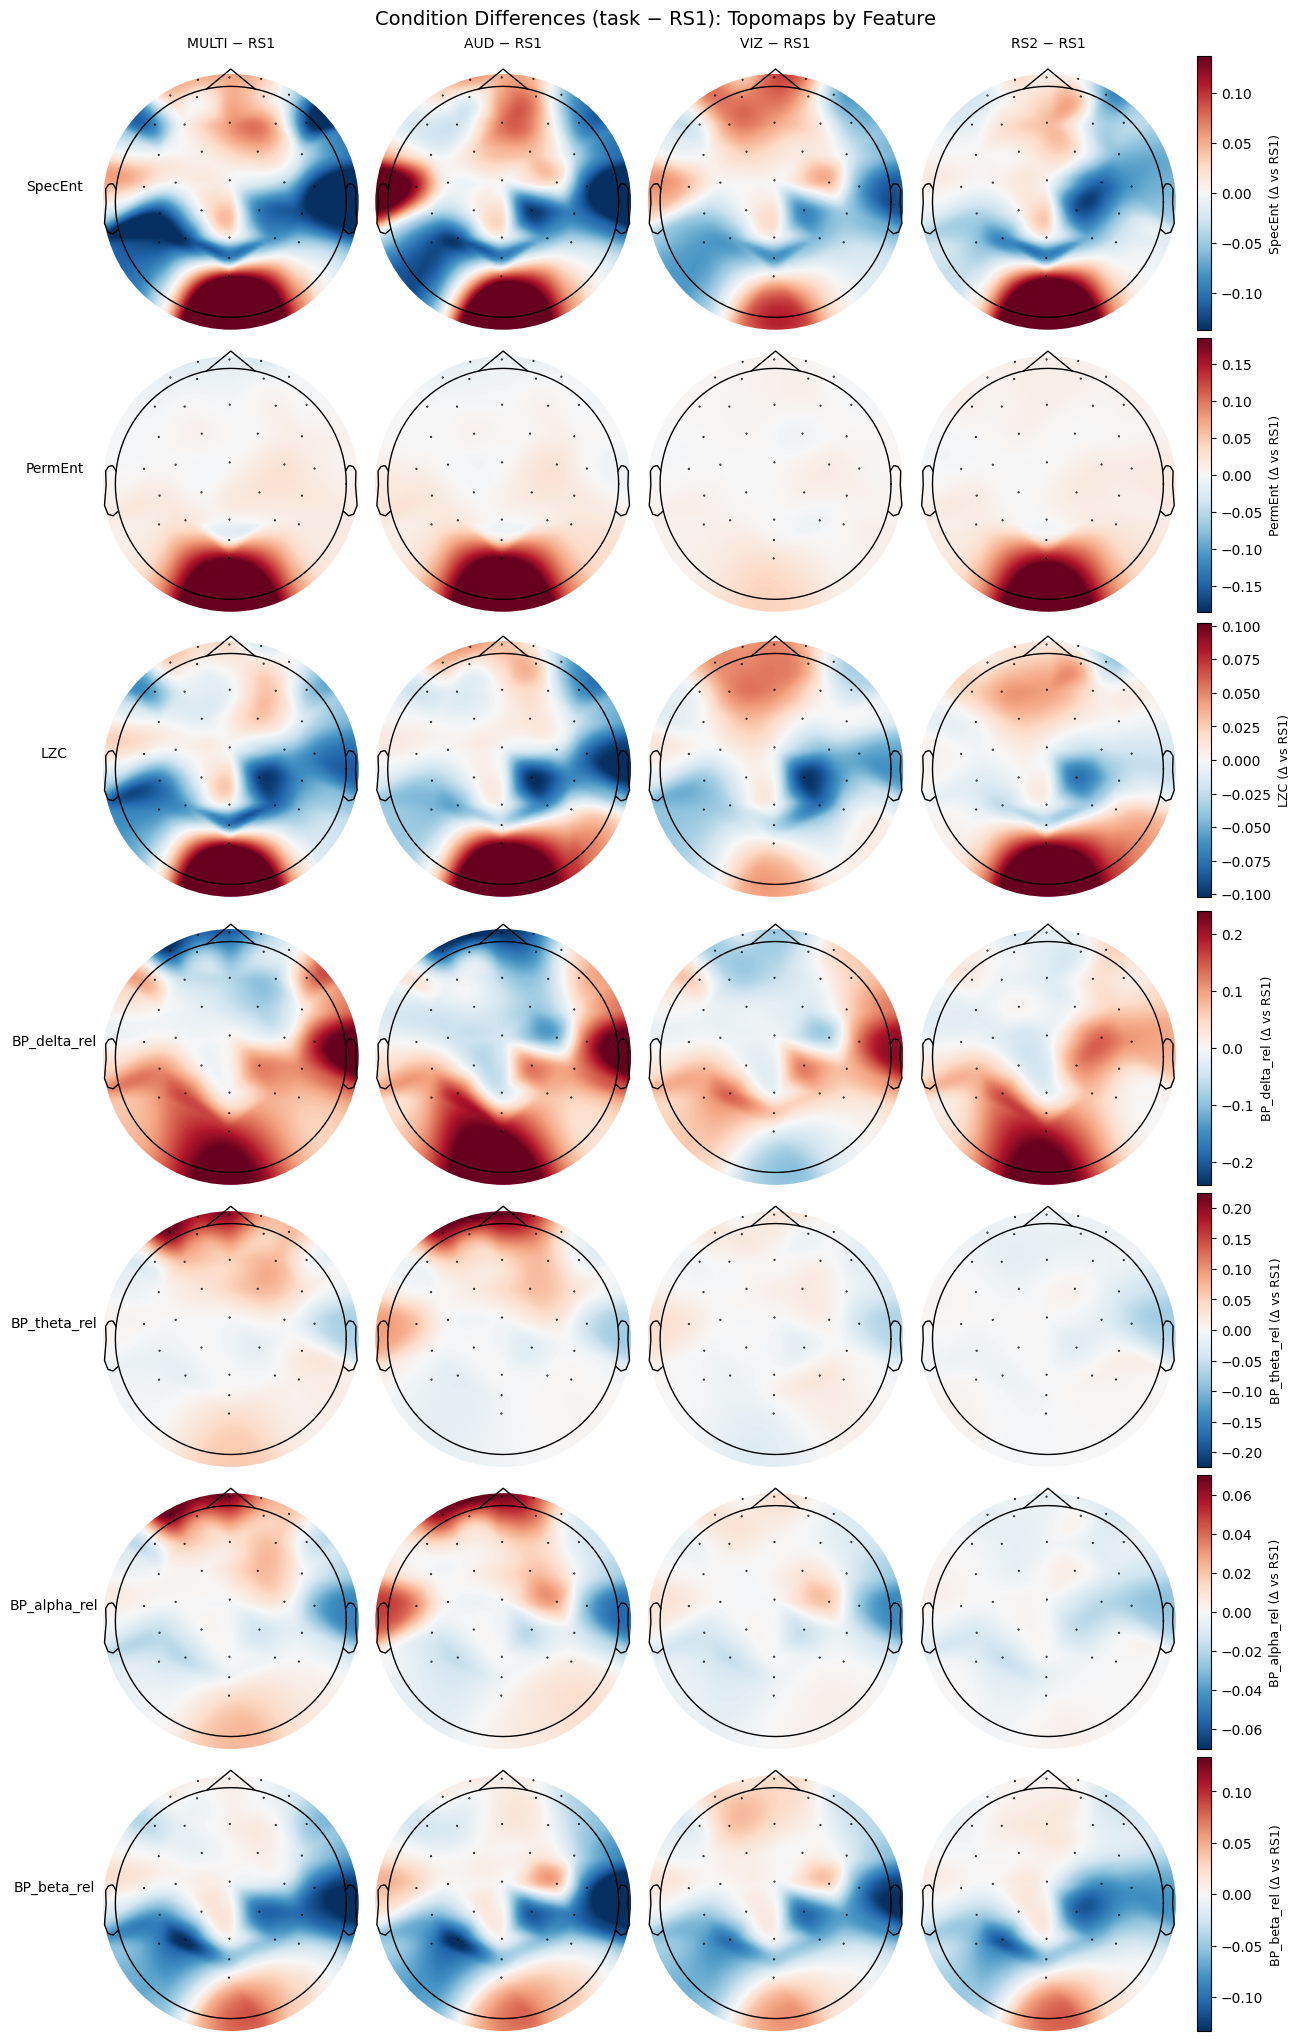

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import mne

base = "RS1"
conds_diff = [c for c in conds if c != base]
features = ["SpecEnt","PermEnt","LZC",
            "BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"]

n_rows, n_cols = len(features), len(conds_diff)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(3.2*n_cols, 2.9*n_rows),
                         constrained_layout=True)

for i, feat in enumerate(features):
    # collect all diffs to set a symmetric vlim per row
    diffs = []
    for cond in conds_diff:
        vals_c = per_channel[cond][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        vals_b = per_channel[base][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        diffs.append((vals_c - vals_b).to_numpy(float))
    vmax = np.nanmax(np.abs(np.hstack(diffs)))
    vlim = (-vmax, vmax) if np.isfinite(vmax) and vmax > 0 else (-1, 1)

    # plot each condition’s diff map in this row
    ims = []
    for j, (cond, data) in enumerate(zip(conds_diff, diffs)):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        im, _ = mne.viz.plot_topomap(
            data, info,
            cmap="RdBu_r",
            vlim=vlim,          # use vlim (newer MNE)
            contours=0,
            outlines="head",
            axes=ax,
            show=False,
        )
        ims.append(im)
        if i == 0:
            ax.set_title(f"{cond} − {base}", fontsize=10)
        if j == 0:
            ax.set_ylabel(features[i], fontsize=10, rotation=0, labelpad=35)

    # one shared colorbar for this row
    cbar = fig.colorbar(ims[0], ax=axes[i, :], orientation="vertical",
                        fraction=0.02, pad=0.02)
    cbar.set_label(f"{feat} (Δ vs {base})", fontsize=9)

fig.suptitle("Condition Differences (task − RS1): Topomaps by Feature", fontsize=14)
plt.show()


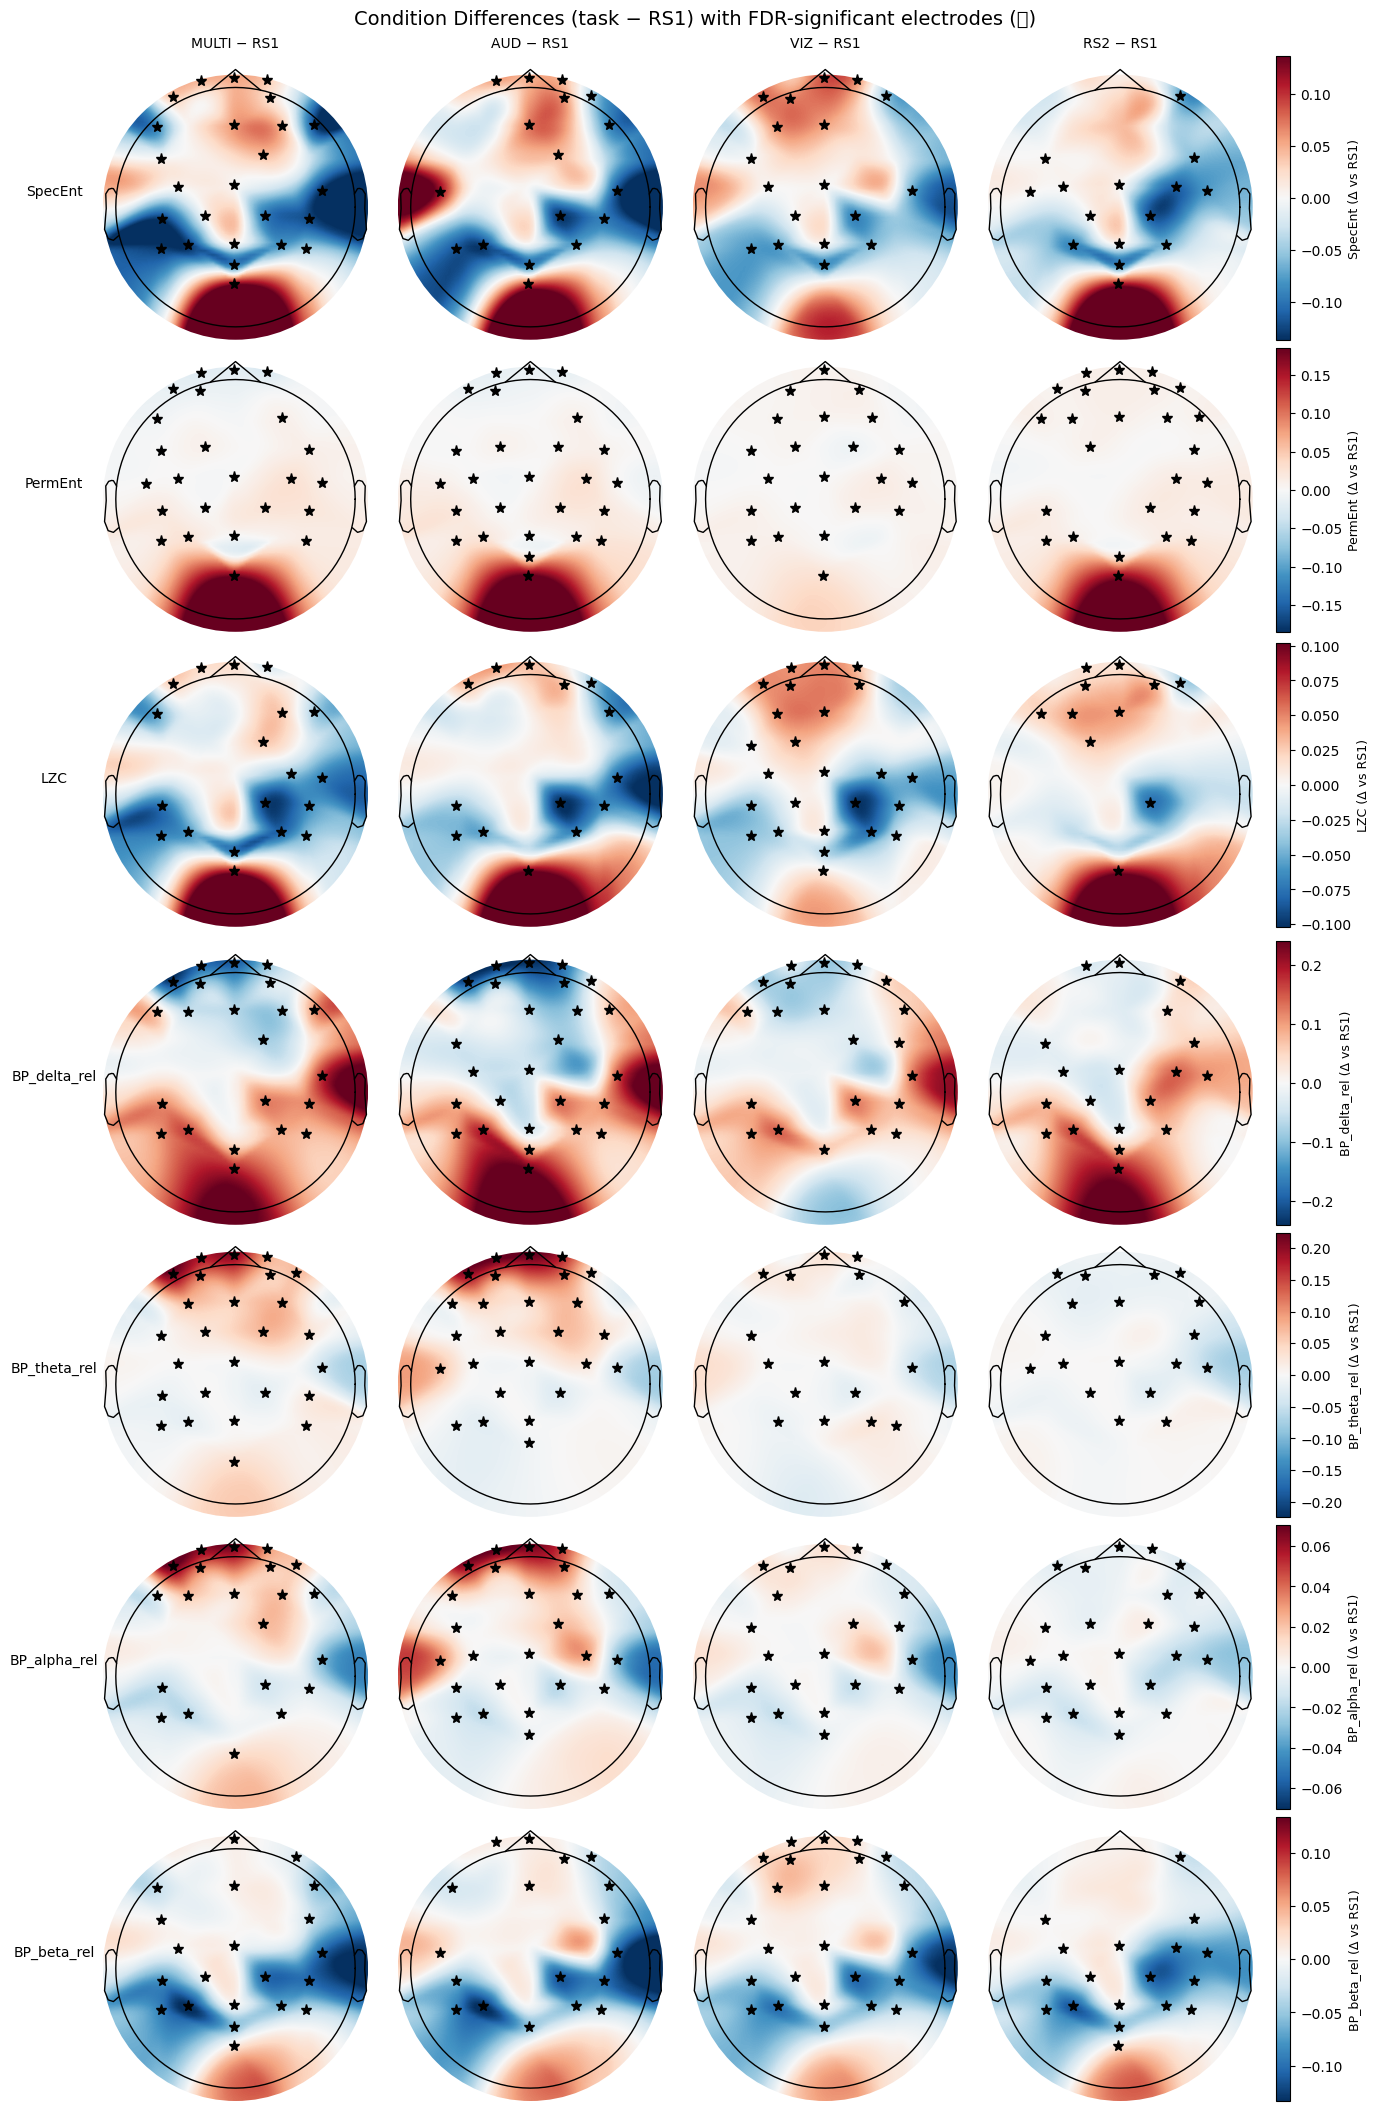

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

base = "RS1"
conds_diff = [c for c in conds if c != base]
features = ["SpecEnt","PermEnt","LZC",
            "BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"]
alpha = 0.05  # FDR threshold

# --- q-values per (feature, condition) and channel (10-20 names) ---
def qvals_per_channel(feature, cond):
    """Return BH-FDR q-values indexed by 10-20 labels for cond vs RS1."""
    pvals, labels = [], []
    for ch_raw, ch_1020 in rename_map.items():
        x = cond_feats[cond].loc[cond_feats[cond]["channel"] == ch_raw, feature].to_numpy()
        y = cond_feats[base].loc[cond_feats[base]["channel"] == ch_raw, feature].to_numpy()
        x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
        if len(x) >= 2 and len(y) >= 2:
            _, p = ttest_ind(x, y, equal_var=False)
        else:
            p = np.nan
        pvals.append(p); labels.append(ch_1020)

    pvals = np.array(pvals, dtype=float)
    qvals = np.full_like(pvals, np.nan, dtype=float)
    mask = ~np.isnan(pvals)
    if mask.sum() > 0:
        _, q, _, _ = multipletests(pvals[mask], alpha=alpha, method="fdr_bh")
        qvals[mask] = q
    return pd.Series(qvals, index=labels).reindex(bitbrain32_labels)

# --- grid: rows = features, cols = conditions minus baseline (Δ vs RS1) ---
n_rows, n_cols = len(features), len(conds_diff)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.4*n_cols, 3.0*n_rows),
                         constrained_layout=True)

for i, feat in enumerate(features):
    # collect diffs for symmetric vlim per feature row
    diffs = []
    for cond in conds_diff:
        vals_c = per_channel[cond][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        vals_b = per_channel[base][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        diffs.append((vals_c - vals_b).to_numpy(float))
    vmax = np.nanmax(np.abs(np.hstack(diffs))) or 1.0
    vlim = (-vmax, vmax)

    ims = []
    for j, (cond, data) in enumerate(zip(conds_diff, diffs)):
        ax = axes[i, j] if n_rows > 1 else axes[j]

        # significance mask: True where q < alpha
        q = qvals_per_channel(feat, cond)                   # Series aligned to bitbrain32_labels
        sig_mask = (q.values < alpha) & ~np.isnan(q.values) # boolean array, len = n_channels

        # plot with star markers at significant sensors
        im, _ = mne.viz.plot_topomap(
            data, info,
            cmap="RdBu_r",
            vlim=vlim,
            contours=0,
            outlines="head",
            axes=ax,
            show=False,
            sensors=False,                 # <- hide sensor dots (optional)
            extrapolate="head",            # <- avoids showing triangulation edges outside head
            mask=sig_mask,
            mask_params=dict(
                marker="*",
                markersize=8,
                markerfacecolor="k",
                markeredgecolor="k",
                linewidth=0.0              # <- no marker edge lines
            ),
        )
        
        ims.append(im)
        if i == 0:
            ax.set_title(f"{cond} − {base}", fontsize=10)
        if j == 0:
            ax.set_ylabel(feat, fontsize=10, rotation=0, labelpad=35)

    # shared colorbar per feature row
    cbar = fig.colorbar(ims[0], ax=axes[i, :], orientation="vertical",
                        fraction=0.02, pad=0.02)
    cbar.set_label(f"{feat} (Δ vs {base})", fontsize=9)

fig.suptitle("Condition Differences (task − RS1) with FDR-significant electrodes (⭐)", fontsize=14)
plt.show()


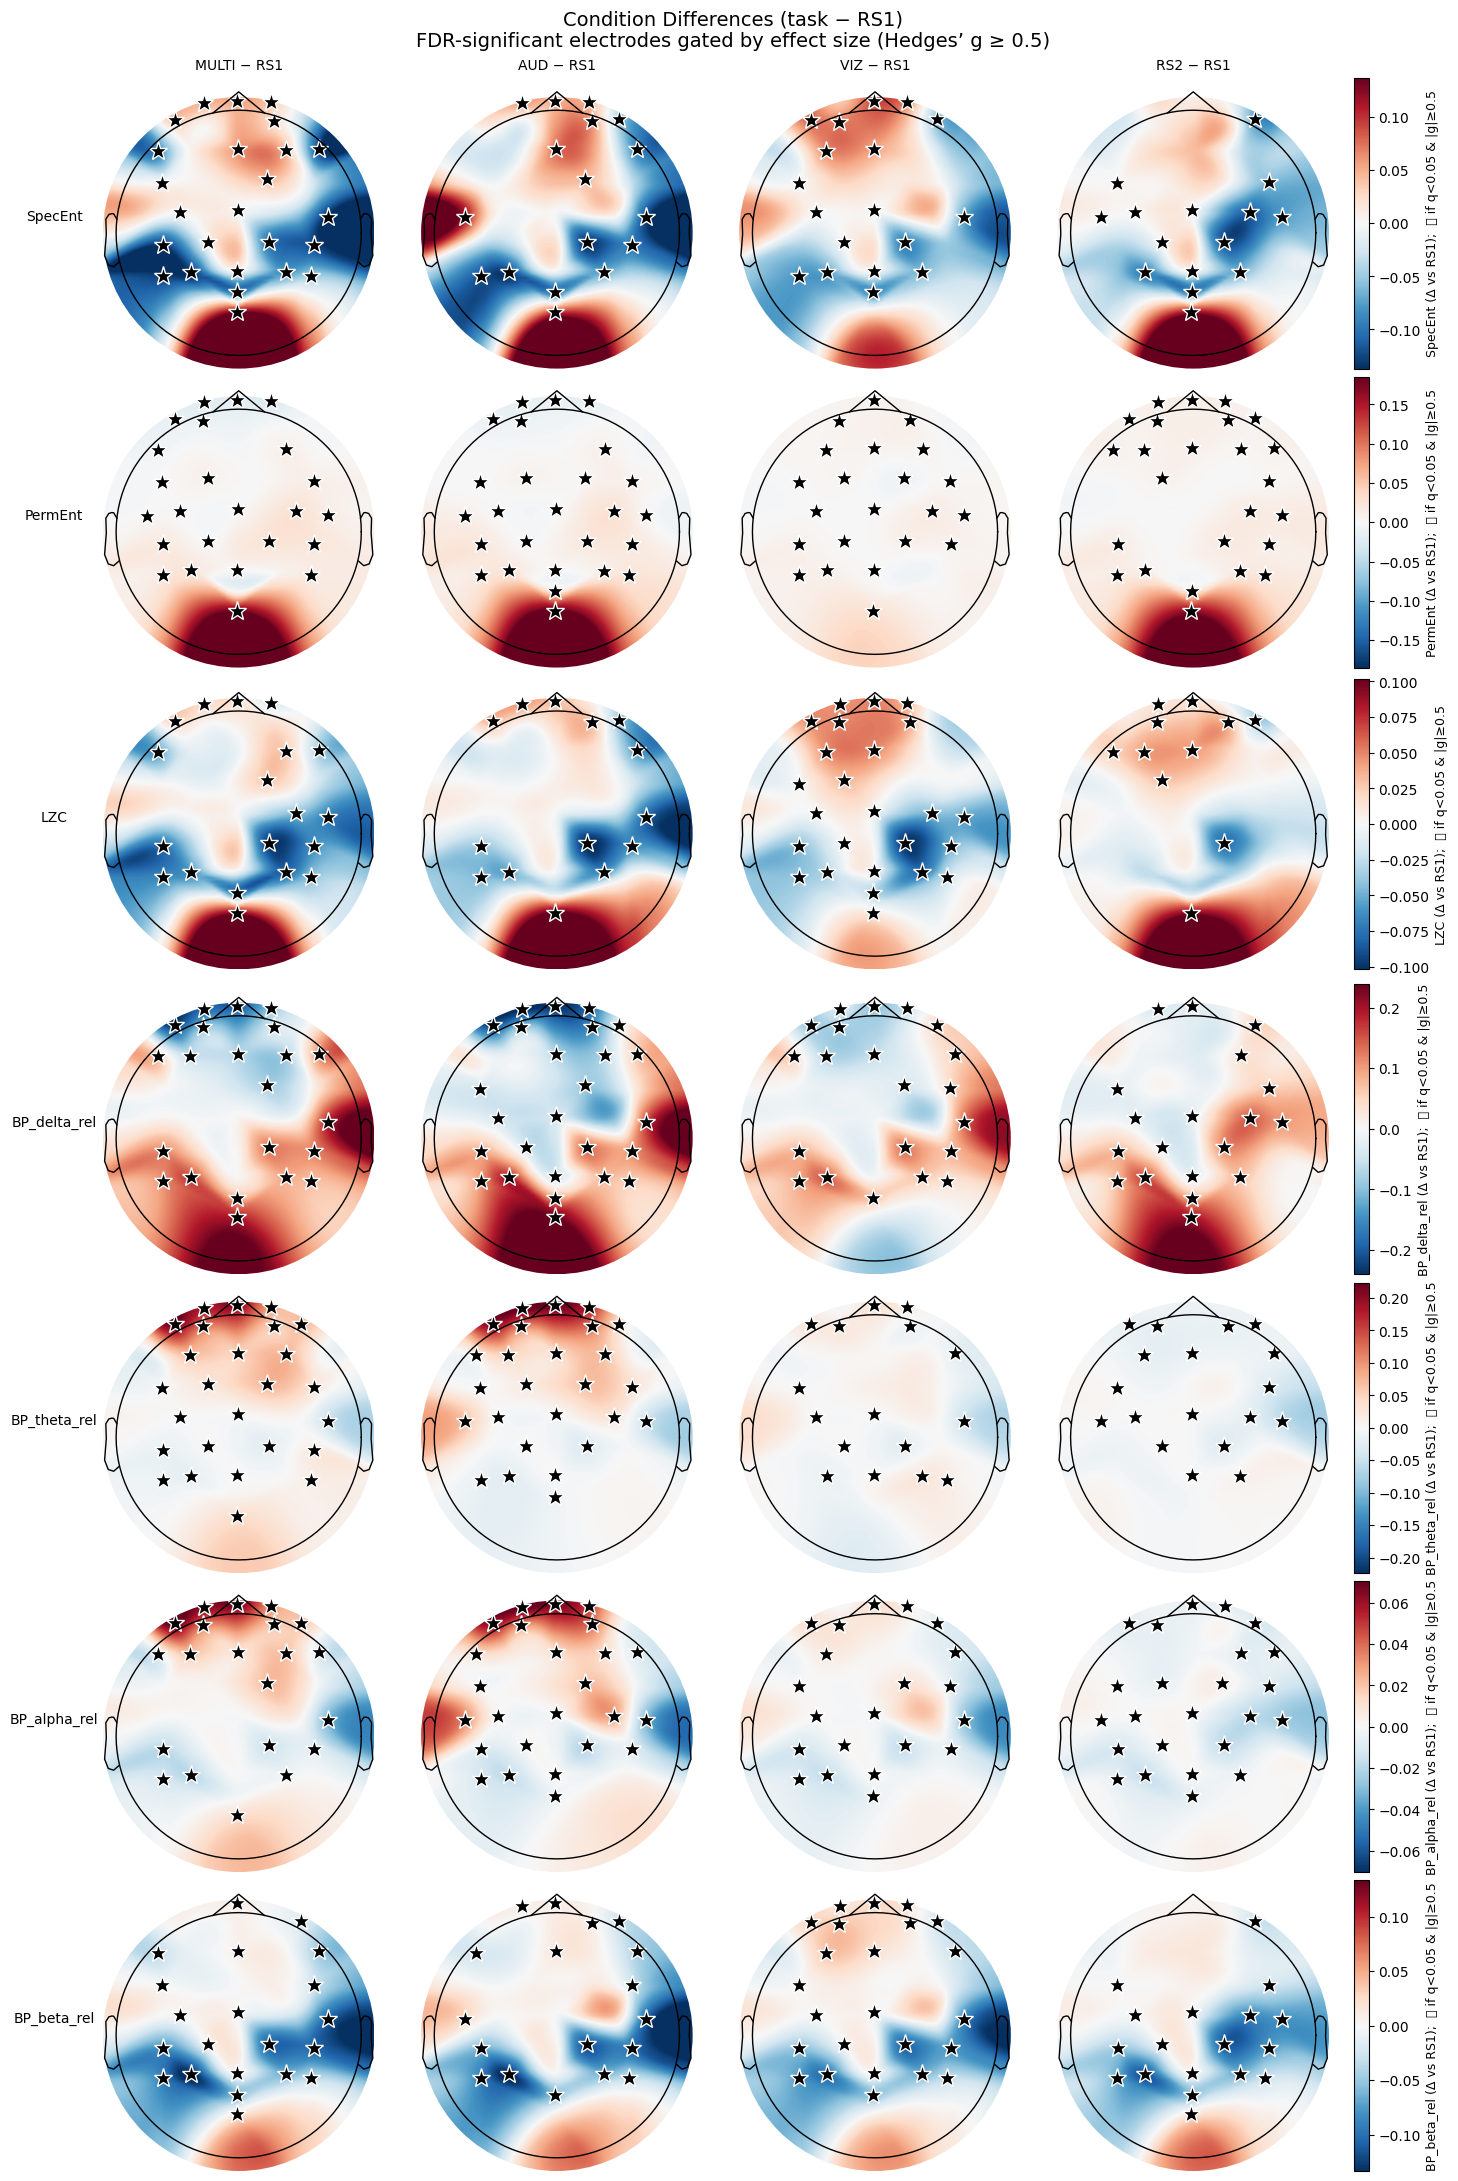

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# ---- config ----
base = "RS1"
conds_diff = [c for c in conds if c != base]
features = ["SpecEnt","PermEnt","LZC",
            "BP_delta_rel","BP_theta_rel","BP_alpha_rel","BP_beta_rel"]
alpha = 0.05          # FDR level
d_thresh = 0.5        # effect-size gate (Hedges' g >= 0.5 => medium)

# Optional: thin overlapped windows to reduce dependency (e.g., take every 5th)
# Set stride=None to use all windows
stride = None  # e.g., 5  # <-- change to 5 or 10 if you want less overlap in stats

def _thin(arr, stride):
    if stride is None or stride <= 1:
        return arr
    return arr[::int(stride)]

def hedges_g(x, y):
    """Hedges' g with pooled SD and small-sample correction."""
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mx, my = np.nanmean(x), np.nanmean(y)
    vx, vy = np.nanvar(x, ddof=1), np.nanvar(y, ddof=1)
    # pooled SD (unbiased variances)
    s_p = np.sqrt(((nx - 1)*vx + (ny - 1)*vy) / (nx + ny - 2))
    if s_p == 0 or not np.isfinite(s_p):
        return np.nan
    d = (mx - my) / s_p
    # small-sample correction
    J = 1.0 - (3.0 / (4.0*(nx + ny) - 9.0)) if (nx + ny) > 2 else 1.0
    return d * J

def d_q_per_channel(feature, cond):
    """Return (d, q) as Series aligned to bitbrain32_labels for cond vs base."""
    d_vals, p_vals, labels = [], [], []
    for ch_raw, ch_1020 in rename_map.items():
        x = cond_feats[cond].loc[cond_feats[cond]["channel"] == ch_raw, feature].to_numpy()
        y = cond_feats[base].loc[cond_feats[base]["channel"] == ch_raw, feature].to_numpy()
        x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
        x = _thin(x, stride); y = _thin(y, stride)

        if len(x) >= 2 and len(y) >= 2:
            # Welch t for p-value
            _, p = ttest_ind(x, y, equal_var=False)
            d = hedges_g(x, y)
        else:
            p, d = np.nan, np.nan

        p_vals.append(p); d_vals.append(d); labels.append(ch_1020)

    # BH-FDR across 32 channels
    p_vals = np.array(p_vals, dtype=float)
    q_vals = np.full_like(p_vals, np.nan, dtype=float)
    mask = ~np.isnan(p_vals)
    if mask.sum() > 0:
        _, q, _, _ = multipletests(p_vals[mask], alpha=alpha, method="fdr_bh")
        q_vals[mask] = q

    d_s = pd.Series(d_vals, index=labels).reindex(bitbrain32_labels)
    q_s = pd.Series(q_vals, index=labels).reindex(bitbrain32_labels)
    return d_s, q_s

# ---- plot grid: rows = features, cols = (cond - RS1), stars gated by q<alpha & |g|>=d_thresh ----
n_rows, n_cols = len(features), len(conds_diff)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.6*n_cols, 3.1*n_rows),
                         constrained_layout=True)

for i, feat in enumerate(features):
    # symmetric color scale per row from condition differences
    diffs = []
    for cond in conds_diff:
        vals_c = per_channel[cond][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        vals_b = per_channel[base][feat].rename(index=rename_map).reindex(bitbrain32_labels)
        diffs.append((vals_c - vals_b).to_numpy(float))
    vmax = np.nanmax(np.abs(np.hstack(diffs))) or 1.0
    vlim = (-vmax, vmax)

    ims = []
    for j, (cond, data) in enumerate(zip(conds_diff, diffs)):
        ax = axes[i, j] if n_rows > 1 else axes[j]

        # effect size & FDR
        d_s, q_s = d_q_per_channel(feat, cond)
        sig_mask = (q_s.values < alpha) & (np.abs(d_s.values) >= d_thresh) & ~np.isnan(q_s.values) & ~np.isnan(d_s.values)

        im, _ = mne.viz.plot_topomap(
            data, info,
            cmap="RdBu_r",
            vlim=vlim,
            contours=0,
            outlines="head",
            axes=ax,
            show=False,
            extrapolate="head",
            sensors=False,
            mask=sig_mask,
            mask_params=dict(marker='*', markersize=14,
                             markerfacecolor='k', markeredgecolor='w',
                             linewidth=0.0)
        )
        ims.append(im)
        if i == 0:
            ax.set_title(f"{cond} − {base}", fontsize=10)
        if j == 0:
            ax.set_ylabel(feat, fontsize=10, rotation=0, labelpad=35)

    cbar = fig.colorbar(ims[0], ax=axes[i, :], orientation="vertical",
                        fraction=0.02, pad=0.02)
    cbar.set_label(f"{feat} (Δ vs {base});  ⭐ if q<{alpha} & |g|≥{d_thresh}", fontsize=9)

fig.suptitle("Condition Differences (task − RS1)\nFDR-significant electrodes gated by effect size (Hedges’ g ≥ 0.5)", fontsize=14)
plt.show()
